.# Geometry

Below we illustrate the 4 essential transformation groups in 2D and 3D.

## Setup

In [1]:
# First, install GTSAM on our VM
!pip install gtsam

In [2]:
# import all necessary modules
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Magic to work animations work in colab
from matplotlib import animation
from IPython.display import HTML

import gtsam
from gtsam import Pose2, Rot2, Point2

ImportError: dlopen(/Users/dellaert/opt/miniconda3/lib/python3.7/site-packages/gtsam-4.1.0-py3.7.egg/gtsam/gtsam.cpython-37m-darwin.so, 2): Symbol not found: __ZN5gtsam4Rot36RzRyRxEddd
  Referenced from: /Users/dellaert/opt/miniconda3/lib/python3.7/site-packages/gtsam-4.1.0-py3.7.egg/gtsam/gtsam.cpython-37m-darwin.so
  Expected in: /Users/dellaert/git/github/build/gtsam/libgtsam.4.dylib
 in /Users/dellaert/opt/miniconda3/lib/python3.7/site-packages/gtsam-4.1.0-py3.7.egg/gtsam/gtsam.cpython-37m-darwin.so

In [0]:
# Set plot parameters
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rc('animation', html='jshtml') # needed for animations!
arrowOptions = dict(head_width=.02,head_length=.02, width=0.01)

The code below defines some drawing functions that works with GTSAM types.

In [33]:
import unittest
from gtsam.utils.test_case import GtsamTestCase

def affine2d_of_pose2(pose : Pose2):
  """Create a matplotlib Affine2D transform from given Pose2."""
  T = mtransforms.Affine2D()
  T.rotate(pose.theta())
  T.translate(pose.x(), pose.y())
  return T

def rect_of_pose2(worldTcenter : Pose2, width=1, height=1):
  """Create a rectangle artist at a given Pose2 `worldTcenter`."""
  centerTcorner = Pose2(-width/2, -height/2,0)
  worldTcorner = worldTcenter.compose(centerTcorner)
  rect = mpatches.Rectangle([worldTcorner.x(),worldTcorner.y()], 
                            width, height, 
                            angle = math.degrees(worldTcorner.theta()))
  return rect

def rect_of_rot2(worldRcenter : Rot2, width=1, height=1):
  """Create a rectangle artist at a given Pose2 `worldTcenter`."""
  worldTcenter = Pose2(0, 0, worldRcenter.theta())
  return rect_of_pose2(worldTcenter)

def pose2_of_rect(rect):
  """Get Pose2 from rectangle.""" 
  worldTcorner = gtsam.Pose2(rect.get_x(), rect.get_y(), math.radians(rect.angle))
  cornerTcenter = Pose2(rect.get_width()/2, rect.get_height()/2, 0)
  return worldTcorner.compose(cornerTcenter)

def draw_bodies(ax, poses, size, Vs_hat):
  """Draw rectangles for all given poses."""
  ax.clear()
  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  for sTb in poses:
    rect = rect_of_pose2(sTb, width=0.4, height=0.4)
    ax.add_artist(rect)
    v = np.dot(Vs_hat, [sTb.x(), sTb.y(), 1])
    ax.add_artist(mpatches.FancyArrow(sTb.x(), sTb.y(), v[0], v[1], color='r', **arrowOptions))
    ax.add_artist(mpatches.FancyArrow(0, 0, Vs_hat[0,2], Vs_hat[1,2], color='g', **arrowOptions))

class TestAll(GtsamTestCase):

  def test_affine2d_of_pose2(self):
    """Test creation of Affine2D from Pose2."""
    pose = Pose2(4, 5, math.radians(30))
    T = affine2d_of_pose2(pose)
    self.assertIsInstance(T, mtransforms.Affine2D)
    np.testing.assert_array_equal(T.get_matrix(), pose.matrix())

  def test_pose2_of_rect_simple(self):
    """Test getting Pose2 of a rectangle."""
    rect = mpatches.Rectangle([0,0], 4, 5)
    pose = pose2_of_rect(rect)
    self.assertEqual(pose.x(), 2)
    self.assertEqual(pose.y(), 2.5)
    self.assertEqual(pose.theta(), rect.angle)

  def test_pose2_of_rect_rotated(self):
    """Test getting Pose2 of a rectangle."""
    theta = angle=math.radians(45)
    rect = mpatches.Rectangle([0,0], 4, 4, angle=45)
    pose = pose2_of_rect(rect)
    self.assertEqual(pose.theta(), theta)
    self.assertAlmostEqual(pose.x(), 0)
    self.assertEqual(pose.y(), math.sin(theta)*4)

  def test_rect_of_pose2_simple(self):
    """Test creation of a rectangle artist at a given Pose2."""
    pose = Pose2(4, 5, 0)
    rect = rect_of_pose2(pose, width=2, height=3)
    self.assertEqual(rect.get_width(), 2)
    self.assertEqual(rect.get_height(), 3)
    self.gtsamAssertEquals(pose2_of_rect(rect), pose)

  def test_rect_of_pose2_rotated(self):
    """Test creation of a rectangle artist at a given Pose2."""
    pose = Pose2(4, 5, math.radians(30))
    rect = rect_of_pose2(pose, width=2, height=3)
    self.gtsamAssertEquals(pose2_of_rect(rect), pose)

if __name__ == '__main__':
  unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.011s

OK


## $SO(2)$
The simplest of all groups is $SO(2)$, the group of rotations in the plane. In GTSAM, these are represented using `Rot2`.

In [34]:
R=Rot2(math.radians(45)); R.matrix()

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

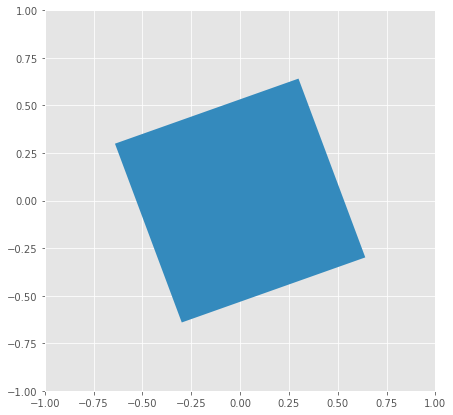

In [35]:
fig, ax = plt.subplots()
size=1
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
ax.add_artist(rect_of_rot2(Rot2(math.radians(20))))
plt.show()

In [36]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()
N=32
size=1.5
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
omega = 2*math.pi/N

# initialization function: plot the background of each frame
def init():
  rect = rect_of_rot2(Rot2(0), width=0.4, height=0.4)
  return (rect,)

# animation function. This is called sequentially  
def animate(i):
  global pose
  rect = rect_of_rot2(Rot2(i*omega), width=0.4, height=0.4)
  ax.clear()
  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.add_artist(rect)

animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=N, interval=100, blit=False)

## $SE(2)$
When we add translation, we get the group of 2D rigid transforms $SE(2)$. In GTSAM, these are represented using `Pose2`.

Below we animate with constant differential body twist $Vb$. We use the formula
$$ sTb \leftarrow sTb \exp(V_b \Delta t)$$
The corresponding spatial twist $Vs$ is *also* constant, and is given by the Adjoint map: $$Vs = 
Ad(sTb) Vb.$$


In [0]:
# Common parameters for SE(2) animations
size=2.5
N=32 # number of frames
dt=100 # time per frame in milliseconds
omega = math.pi/4 # radians per second
fig, ax = plt.subplots()
plt.close()
ax.set_xlim((-size, size))
ax.set_ylim((-size, size));

In [47]:
M=5
R = 1.0
poses = [Pose2(0,0,i*2*math.pi/M).compose(Pose2(R,0,0)) for i in range(M)]
v_x, v_y = 0, R * omega
Vb = np.array([v_x, v_y, omega]) # body twist
Vs = poses[0].Adjoint(Vb)
Vs_hat = np.array([[0,-Vs[2],Vs[0]],[Vs[2],0,Vs[1]]]) # only 2*3 top part
print("Vb = ", Vb, "Vs = ", Vs)
icr = np.array([-v_y, v_x])/omega
print("ICR in body coordinates: ", icr)

def init():
  rects = [rect_of_pose2(sTb, width=0.4, height=0.4) for sTb in poses]
  return rects

def animate(i):
  global poses
  draw_bodies(ax, poses, size, Vs_hat)
  poses = [sTb.compose(Pose2.Expmap(Vb*dt/1000)) for sTb in poses]

animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=N, interval=dt, blit=False)

Vb =  [0.         0.78539816 0.78539816] Vs =  [0.         0.         0.78539816]
ICR in body coordinates:  [-1.  0.]


In [0]:
#anim.save('body-twist.mpg')

And here is constant spatial differential twist.We use the formula
$$ sTb \leftarrow \exp(V_b \Delta t) sTb$$
The corresponding body twist $Vb$ is *also* constant, and is given by the Adjoint map: $$Vb = 
Ad(sTb^{-1}) Vs.$$


In [48]:
M=5
R = 1.0
poses = [Pose2(-1,0,i*2*math.pi/M).compose(Pose2(R,0,0)) for i in range(M)]
R = 1.0
v_x, v_y = 0, R * omega
Vs = np.array([v_x, v_y, omega]) # spatial twist
Vs_hat = np.array([[0,-Vs[2],Vs[0]],[Vs[2],0,Vs[1]]]) # only 2*3 top part
icr = np.array([-v_y, v_x])/omega
print("ICR is now in spatial coordinates: ", icr)

def animate(i):
  global poses
  draw_bodies(ax, poses, size, Vs_hat)
  poses = [Pose2.Expmap(Vs*dt/1000).compose(sTb) for sTb in poses]

animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=N, interval=dt, blit=False)

ICR is now in spatial coordinates:  [-1.  0.]
